# Predicting Business Popularity
##### Pytorch Geometric implementation with NetworkX graph

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     |████████████████████████████████| 2.6MB 3.5MB/s 
     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 215kB 8.0MB/s 
     |████████████████████████████████| 235kB 26.3MB/s 
     |████████████████████████████████| 2.2MB 28.4MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn

import networkx as nx
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating the network graph datasets

We use NetworkX to read and parse the graph into train/validate/test sets. We load these into DataLoader to use mini-batching.

In [4]:
G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurants_MA.gpickle")

In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 6192
Number of edges: 40605


In [6]:
H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

In [66]:
print(dataset.graphs[0].node_feature)

tensor([[ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  9.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.0000, 16.0000,  0.8670],
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  3.0000,  1.0000],
        ...,
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000, 12.0000,  0.9700],
        [ 4.0000,  1.0000,  1.0000,  ...,  0.0000, 32.0000,  0.6390],
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  4.0000,  1.0000]])


In [7]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

There are 59 features and 3 labels.


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the popularity category, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_node_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=59, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [10]:
x = dataset.graphs[0].node_feature
y = dataset.graphs[0].node_label

print(x.size())
print(y.size())

torch.Size([6192, 59])
torch.Size([6192])


In [11]:
import numpy as np

mask = np.random.rand(1, y.size()[0])

train_mask = (mask < 0.9)[0]
test_mask = (mask >= 0.9)[0]

print(train_mask)
print(test_mask)

[False  True  True ...  True  True  True]
[ True False False ... False False False]


In [12]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(x)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 500):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.2156
Epoch: 002, Loss: 1.1261
Epoch: 003, Loss: 1.0973
Epoch: 004, Loss: 1.0853
Epoch: 005, Loss: 1.0721
Epoch: 006, Loss: 1.0678
Epoch: 007, Loss: 1.0523
Epoch: 008, Loss: 1.0483
Epoch: 009, Loss: 1.0417
Epoch: 010, Loss: 1.0384
Epoch: 011, Loss: 1.0327
Epoch: 012, Loss: 1.0325
Epoch: 013, Loss: 1.0244
Epoch: 014, Loss: 1.0203
Epoch: 015, Loss: 1.0110
Epoch: 016, Loss: 1.0077
Epoch: 017, Loss: 1.0037
Epoch: 018, Loss: 0.9966
Epoch: 019, Loss: 0.9950
Epoch: 020, Loss: 0.9855
Epoch: 021, Loss: 0.9852
Epoch: 022, Loss: 0.9781
Epoch: 023, Loss: 0.9811
Epoch: 024, Loss: 0.9701
Epoch: 025, Loss: 0.9681
Epoch: 026, Loss: 0.9655
Epoch: 027, Loss: 0.9627
Epoch: 028, Loss: 0.9616
Epoch: 029, Loss: 0.9554
Epoch: 030, Loss: 0.9508
Epoch: 031, Loss: 0.9516
Epoch: 032, Loss: 0.9550
Epoch: 033, Loss: 0.9541
Epoch: 034, Loss: 0.9452
Epoch: 035, Loss: 0.9491
Epoch: 036, Loss: 0.9475
Epoch: 037, Loss: 0.9447
Epoch: 038, Loss: 0.9394
Epoch: 039, Loss: 0.9449
Epoch: 040, Loss: 0.9325


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [13]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5611


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


In [29]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        elif model_type == "TransformerConv":
            return pyg_nn.TransformerConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))

In [61]:
def train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    losses = []
    accuracies = []

    for epoch in range(args['epochs']):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test_gnn(train_loader, model, device)
        val_acc = test_gnn(val_loader, model, device)
        test_acc = test_gnn(test_loader, model, device)

        print(f"Epoch {epoch + 1}: Train: {train_acc:.4f}, Validation: {val_acc:.4f}. Test: {test_acc:.4f}, Loss: {total_loss:.4f}")

        losses.append(round(total_loss, 4))
        accuracies.append(test_acc)

    return (model, losses, accuracies)

def test_gnn(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [62]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 250})'''))

args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 64,
    "epochs" : 300,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN, TransformerConv]
}

gnn_model, losses, accuracies = train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

<IPython.core.display.Javascript object>

GNN(
  (convs): ModuleList(
    (0): SAGEConv(59, 64)
    (1): SAGEConv(64, 64)
  )
  (post_mp): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 1: Train: 0.1407, Validation: 0.1389. Test: 0.1500, Loss: 5.3578
Epoch 2: Train: 0.4454, Validation: 0.4782. Test: 0.4565, Loss: 3.4861
Epoch 3: Train: 0.4642, Validation: 0.4960. Test: 0.4468, Loss: 2.4246
Epoch 4: Train: 0.4432, Validation: 0.4701. Test: 0.4355, Loss: 1.7550
Epoch 5: Train: 0.4121, Validation: 0.4346. Test: 0.4226, Loss: 1.3918
Epoch 6: Train: 0.4589, Validation: 0.5089. Test: 0.4565, Loss: 1.2757
Epoch 7: Train: 0.4783, Validation: 0.5105. Test: 0.4677, Loss: 1.1904
Epoch 8: Train: 0.4195, Validation: 0.4556. Test: 0.4194, Loss: 1.1675
Epoch 9: Train: 0.4741, Validation: 0.5121. Test: 0.4645, Loss: 1.1562
Epoch 10: Train: 0.4692, Validation: 0.5153. Test: 0.4581, Loss: 1.1026
Epoch 11: Train: 0.4430, Validation: 0.4895. Test: 0.4387, Loss: 1.0789
Epoch 12: Train: 0.4928, Validation: 0.5218. Test: 0.4806, Loss: 1.0

### Plotting training data 

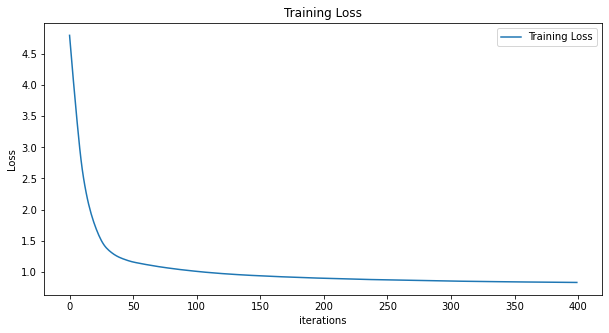

In [17]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

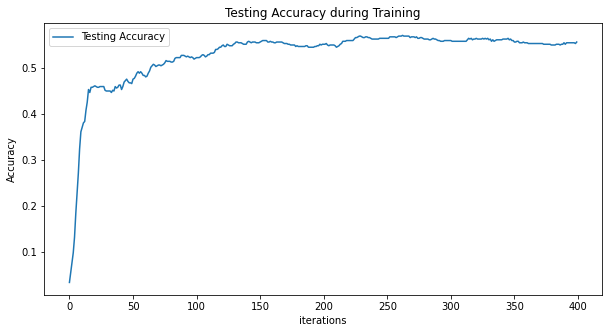

In [18]:
plt.figure(figsize=(10,5))
plt.title("Testing Accuracy during Training")
plt.plot(accuracies,label="Testing Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Report

In [63]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))

y_pred = None
y_true = None

gnn_model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = gnn_model(batch)
    y_pred = logits[batch.node_label_index].max(1)[1]
    y_true = batch.node_label

In [64]:
from sklearn.metrics import classification_report

target_names = ['Low', 'Middle', 'High']
print(classification_report(y_true.cpu(), y_pred.cpu(), target_names=target_names))

              precision    recall  f1-score   support

         Low       0.68      0.63      0.65       235
      Middle       0.49      0.41      0.45       209
        High       0.54      0.69      0.61       176

    accuracy                           0.57       620
   macro avg       0.57      0.58      0.57       620
weighted avg       0.57      0.57      0.57       620



In [65]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true.cpu(), y_pred.cpu())

array([[[316,  69],
        [ 88, 147]],

       [[320,  91],
        [123,  86]],

       [[339, 105],
        [ 54, 122]]])